In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### TO SUPPRESS
import sys
sys.path.insert(0,'../debvader')
from debvader import load_deblender, deblend, deblend_field, iterative_deblending
####

#import debvader

### Deblend stamps randomly generated from DC2 data

Load 10 DC2 images centred on galaxy. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [2]:
path_folder = os.path.dirname(os.path.abspath("__file__"))
images = np.load(path_folder+'/../data/dc2_imgs/imgs_dc2.npy', mmap_mode = 'c')

Visualize some of the images

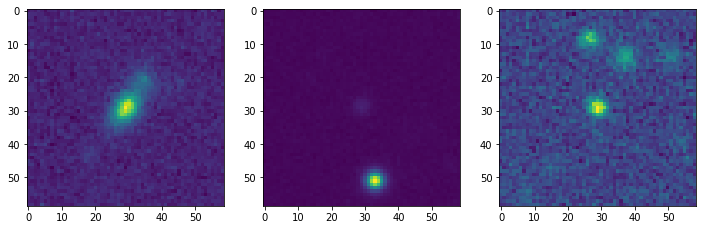

In [3]:
fig, axes = plt.subplots(1,3, figsize = (12, 4))
for i in range (3):
    axes[i].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)

Now we can load the deblender

In [4]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 32
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [5]:
# Load the network using the load_deblender function
net, encoder, decoder, z = load_deblender(survey, input_shape, latent_dim, filters, kernels, return_encoder_decoder_z=True)

in cropping
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
/pbs/throng/lsst/users/barcelin/debvader/debvader/../data/weights/dc2/not_normalised/loss/


In [6]:
# We can visualize the network
net.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 59, 59, 6)]       0         
_________________________________________________________________
model (Model)                (None, 560)               3741224   
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 32), (None, 32))  0         
_________________________________________________________________
model_1 (Model)              (None, 59, 59, 6)         4577228   
Total params: 8,318,452
Trainable params: 3,741,212
Non-trainable params: 4,577,240
_________________________________________________________________


We now have everything to do the deblending. Let's use our network to deblend the DC2 images

In [7]:
output_images_mean, output_images_distribution = deblend(net, images)

Here the network outputs a distribution over the pixels for each pixel in each filter, this is why both the mean image and the corresponding distribution is outputed.

Let's first visualize the mean images outputed by debvader.

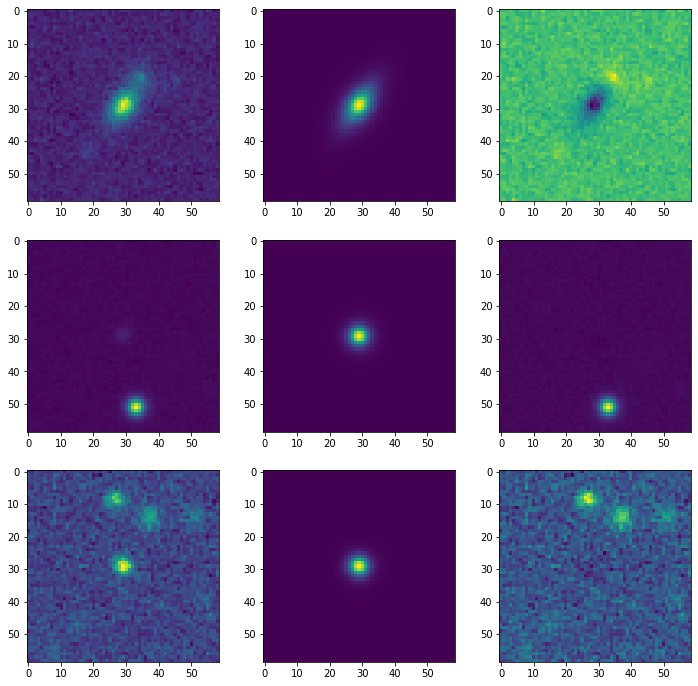

In [8]:
fig, axes = plt.subplots(3,3, figsize = (12, 12))
for i in range (3):
    axes[i,0].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)
    axes[i,1].imshow(output_images_mean[i,:,:,2]) # We plot only r-band here, but the output images are multi-bands (ugrizy)
    axes[i,2].imshow(images[i,:,:,2]-output_images_mean[i,:,:,2])

Now we can look at what the images of the standard deviation look like for each example, and how we can sample this distribution in each pixel.

In [9]:
output_uncertainty_mean = output_images_distribution.mean().numpy() # Extract the mean of the distribution. Same image as output_images_mean.
output_uncertainty_std = output_images_distribution.stddev().numpy() # Extract the standard deviation of the distribution.
output_uncertainty_sample = tf.math.reduce_mean(output_images_distribution.sample(100), axis = 0).numpy() # Sample 100 times the distribution in each pixel and produce a mean image.

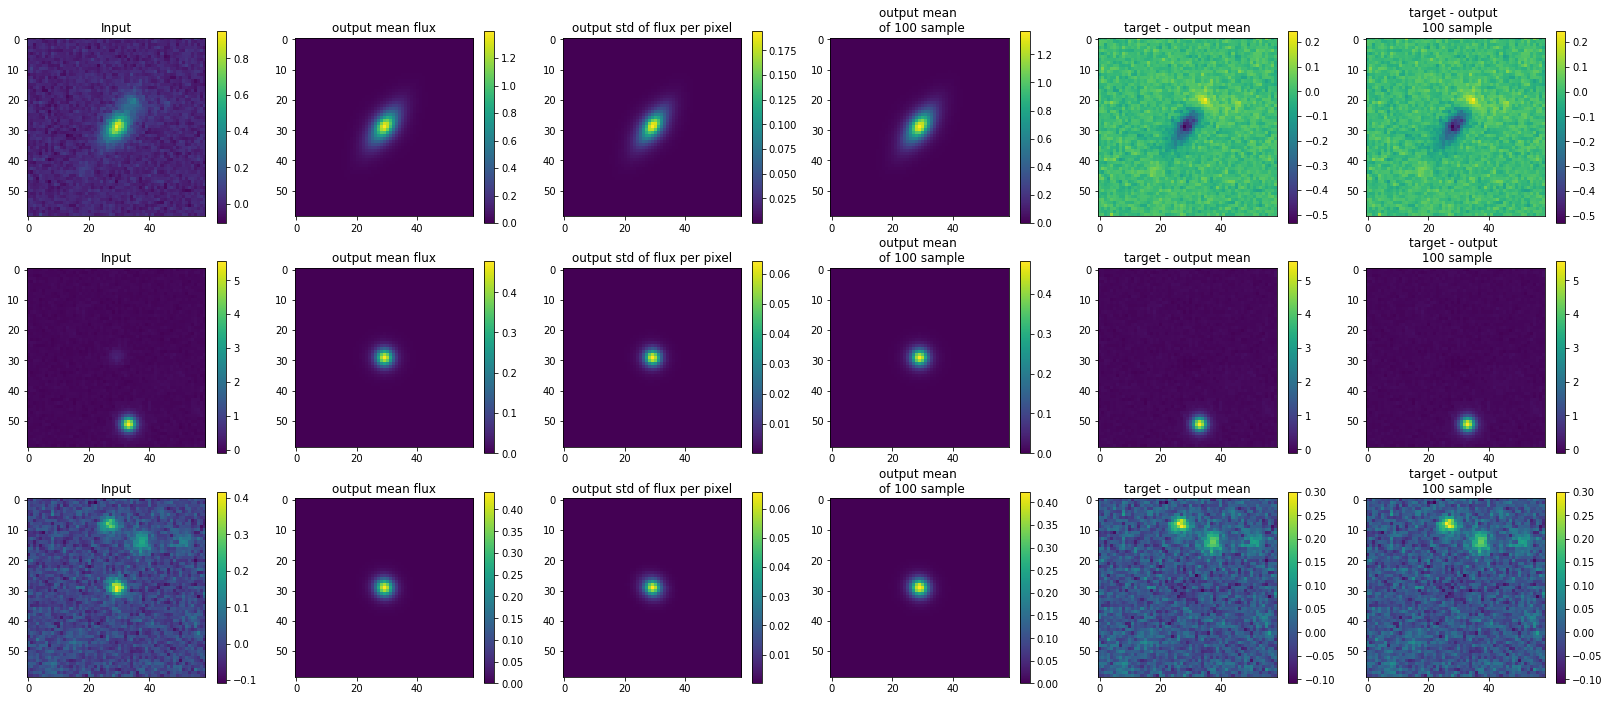

In [10]:
fig, axes = plt.subplots(3,6, figsize = (28, 12))

for i in range (3):
    f1 = axes[i,0].imshow(images[i,:,:,2])
    f2 = axes[i,1].imshow(output_uncertainty_mean[i,:,:,2])
    f3 = axes[i,2].imshow(output_uncertainty_std[i,:,:,2])
    f4 = axes[i,3].imshow(output_uncertainty_sample[i,:,:,2])
    f5 = axes[i,4].imshow(images[i,:,:,2] - output_uncertainty_mean[i,:,:,2])
    f6 = axes[i,5].imshow(images[i,:,:,2] - output_uncertainty_sample[i,:,:,2])
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    fig.colorbar(f4, ax = axes[i,3])
    fig.colorbar(f5, ax = axes[i,4])
    fig.colorbar(f6, ax = axes[i,5])

    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean flux')
    axes[i,2].set_title('output std of flux per pixel')
    axes[i,3].set_title('output mean \n of 100 sample')
    axes[i,4].set_title('target - output mean')
    axes[i,5].set_title('target - output \n 100 sample')

### Deblend a DC2 field

Load DC2 field image and corresponding galaxy stamps. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [12]:
path_folder = os.path.dirname(os.path.abspath("__file__"))
field_img = np.load(path_folder+'/../data/dc2_imgs/field/field_img.npy', mmap_mode = 'c') # DC2 field image
cutout_galaxy_img = np.load(path_folder+'/../data/dc2_imgs/field/galaxies_from_field.npy', mmap_mode = 'c') # stamps from galaxies below a magnitude of 24.5 in the r-band
field_galaxies_distances_from_center = np.load(path_folder+'/../data/dc2_imgs/field/ra_dec_coord.npy', allow_pickle=True) # Distances from center of the different galaxies from object catalog (in pixels). Mag cut at 24.5
all_field_galaxies_distances_from_center_truth = np.load(path_folder+'/../data/dc2_imgs/field/gal_coordinates_complete_truth_catalog.npy', allow_pickle=True) # Distances from center of the field for the galaxies from the DC2 truth catalog (in pixels). Mag cut at 26

field_img_saving_iter = field_img.copy()

Set some parameters:

In [12]:
cutout_size = 59 # pixels
field_size = 259 # pixels
nb_of_bands = 6 # six LSST filters

Retrieve coordinates in pixels from the DC2 simulation of the field center and of each galaxy detected (with a magnitude cut at 24.5 in the $r$-band).

In [13]:
field_center = field_galaxies_distances_from_center[0]
galaxies_coord = field_galaxies_distances_from_center[1]

and of the galaxies from the truth catalog (with a magnitude cut at 26 in the $r$-band).

In [14]:
galaxies_coord_truth = all_field_galaxies_distances_from_center_truth

Compute distances (in pixels) of galaxies from the center of the field:

In [15]:
galaxy_distances_to_center = []
for i in range(len(galaxies_coord)):
    galaxy_distances_to_center.append((int(-field_center[1]+galaxies_coord[i][1]), int(-field_center[0]+galaxies_coord[i][0])))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

Feed the deblend_field with the required paramter, including the distances of the galaxies from the center of the field (it is also possible to directly include the cutouts. Here I show an example where we do not have the cutouts in advance):

In [16]:
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean, output_images_distribution, shift, list_idx = deblend_field(net, 
                                                                                                                                                                                        field_img, 
                                                                                                                                                                                        galaxy_distances_to_center)

The function outputs both the initial field and the field subtracted from the deblended galaxies. It also provide an image of the model proposed by the deblender for the denoised field.

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

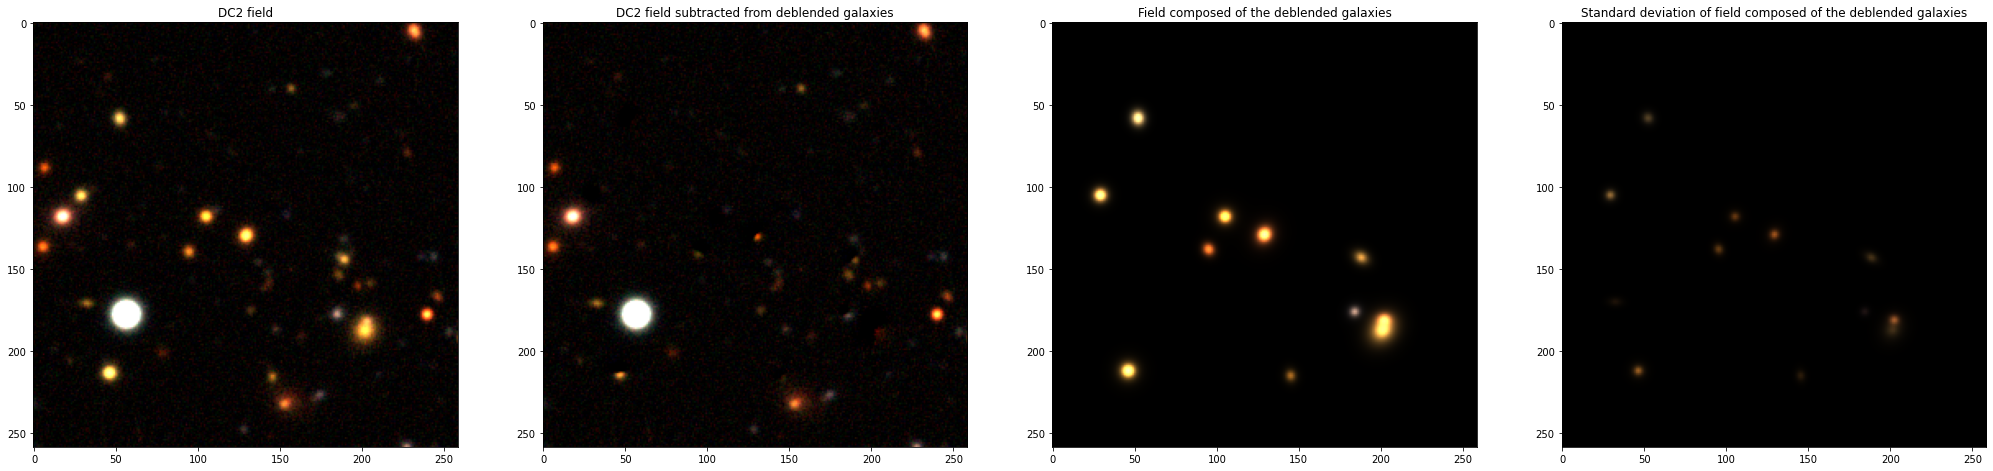

In [17]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

We can see that there are still some residuals on the DC2 field subtracted from the deblended galaxies...

To improve this we can use the `optimize` module from `scipy` to look for the position that minimises the mean squared error between the true DC2 field and the one reconstructed from the deblended galaxies. For that we set the argument `optimise position` to **True**.

In [18]:
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean, output_images_distribution, shifts, list_idx = deblend_field(net, 
                                                                                                                                                                                            field_img, 
                                                                                                                                                                                            galaxy_distances_to_center, 
                                                                                                                                                                                            optimise_positions=True)

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

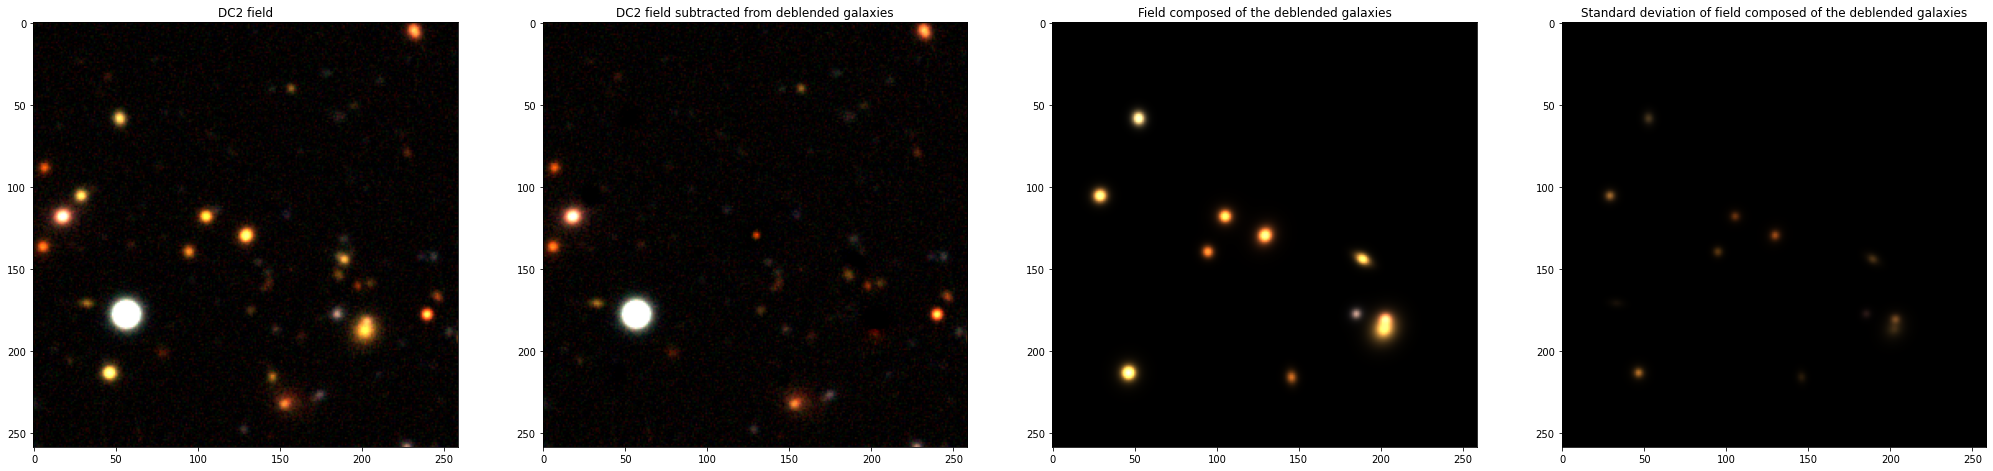

In [19]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

**Note**: it is also possible to provide the cutout images directly to the deblended function is you already have extracted them using another algorithm. To do so, you must feed them to the `cutout_images` argument as shown below:

In [20]:
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean, output_images_distribution, shifts, list_idx = deblend_field(net, 
                                                                                                                                                                                            field_img_saving_iter, 
                                                                                                                                                                                            galaxy_distances_to_center, 
                                                                                                                                                                                            cutout_images= cutout_galaxy_img, 
                                                                                                                                                                                            optimise_positions=True)

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

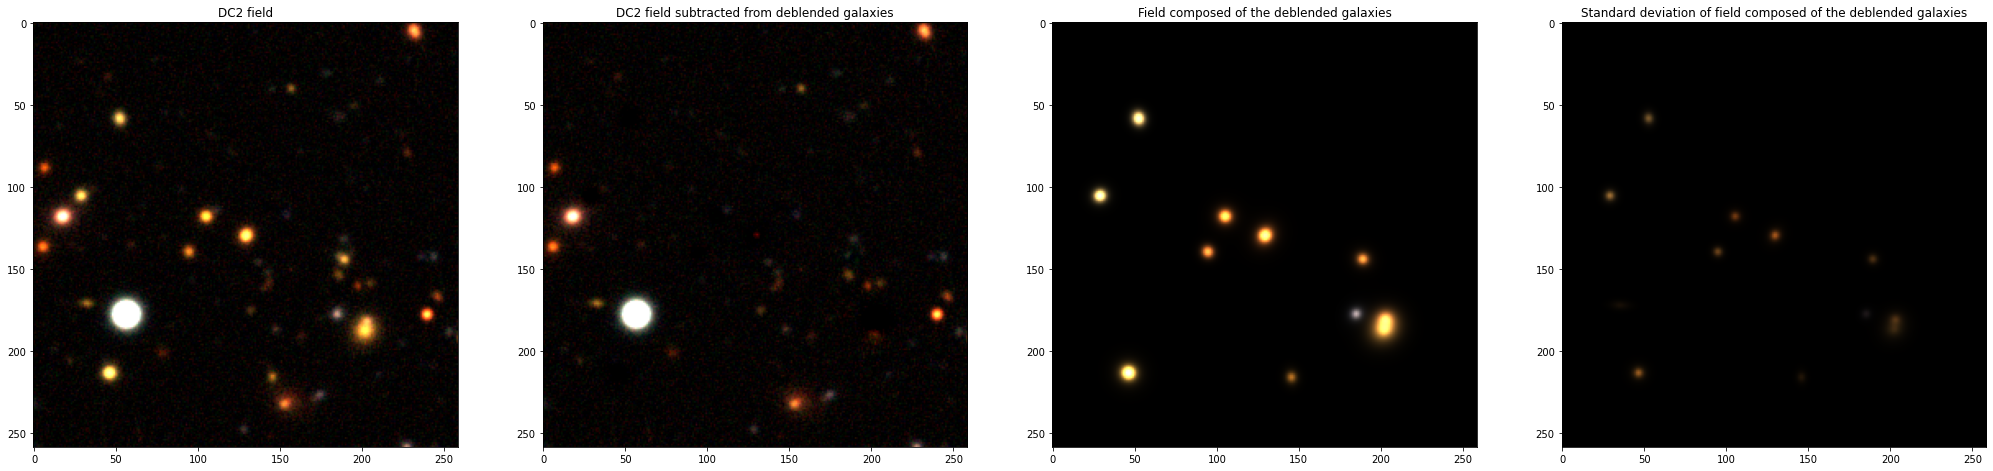

In [21]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

If we feed to the network all the positions of the galaxies below a magnitude of 26 in the $r$-band. We need first to compute the distances from the center once again with all these galaxies:

In [22]:
galaxies_coordinates = np.array(all_field_galaxies_distances_from_center_truth)

galaxy_distances_to_center = []
for i in range(all_field_galaxies_distances_from_center_truth.shape[0]):
    galaxy_distances_to_center.append((int(-field_center[1]+all_field_galaxies_distances_from_center_truth[i][1]), int(-field_center[0]+all_field_galaxies_distances_from_center_truth[i][0])))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

In [23]:
len(galaxy_distances_to_center)

43

Now do the deblending:

In [24]:
import time
t0 = time.time()
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean, output_images_distribution, shifts, list_idx = deblend_field(net, 
                                                                                                                                                                                            field_img_saving_iter, 
                                                                                                                                                                                            galaxy_distances_to_center, 
                                                                                                                                                                                            optimise_positions=True)
print('The deblending of the field took '+str(time.time()-t0)+' seconds.')

Some galaxies are too close from the border of the field to be considered here.
The deblending of the field took 21.27019238471985 seconds.


And look at the resulting fields with red crosses superposed to the field on the positions of the galaxies from the truth catalog below a magnitude of 26 in the $r$-band.

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

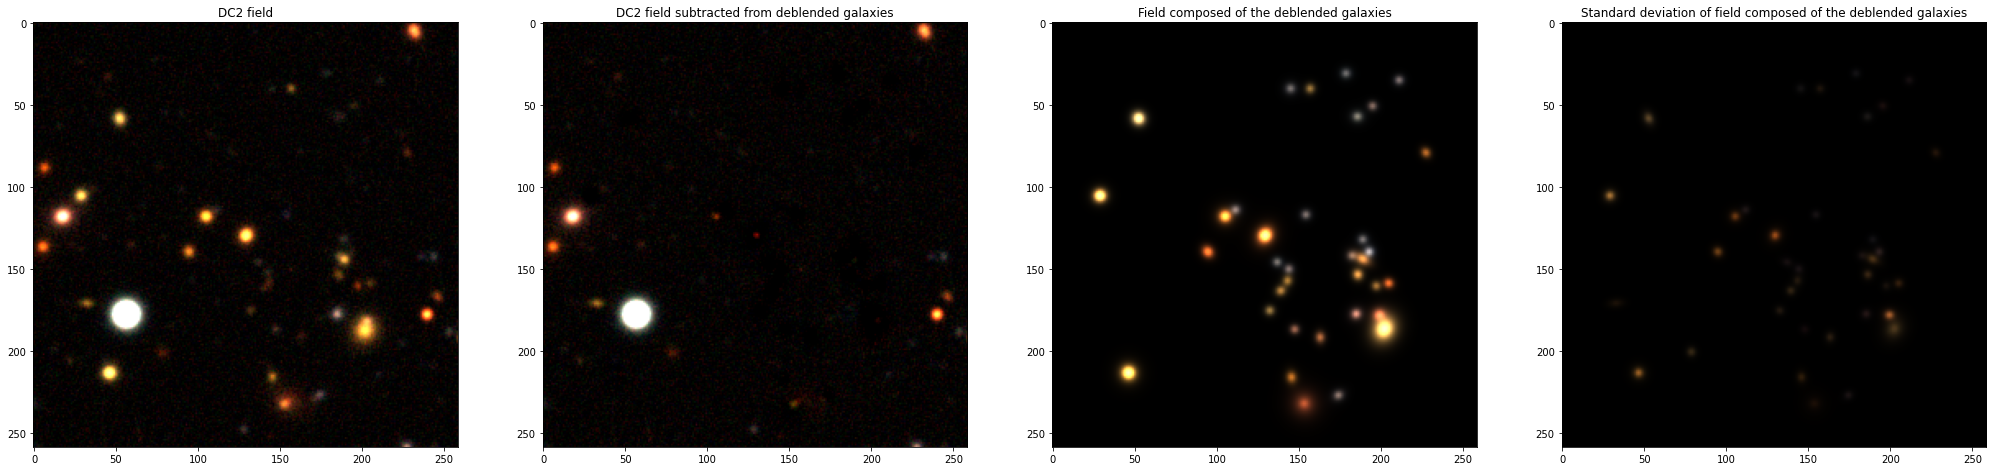

In [25]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

Text(0.5, 1.0, 'Field composed of the deblended galaxies')

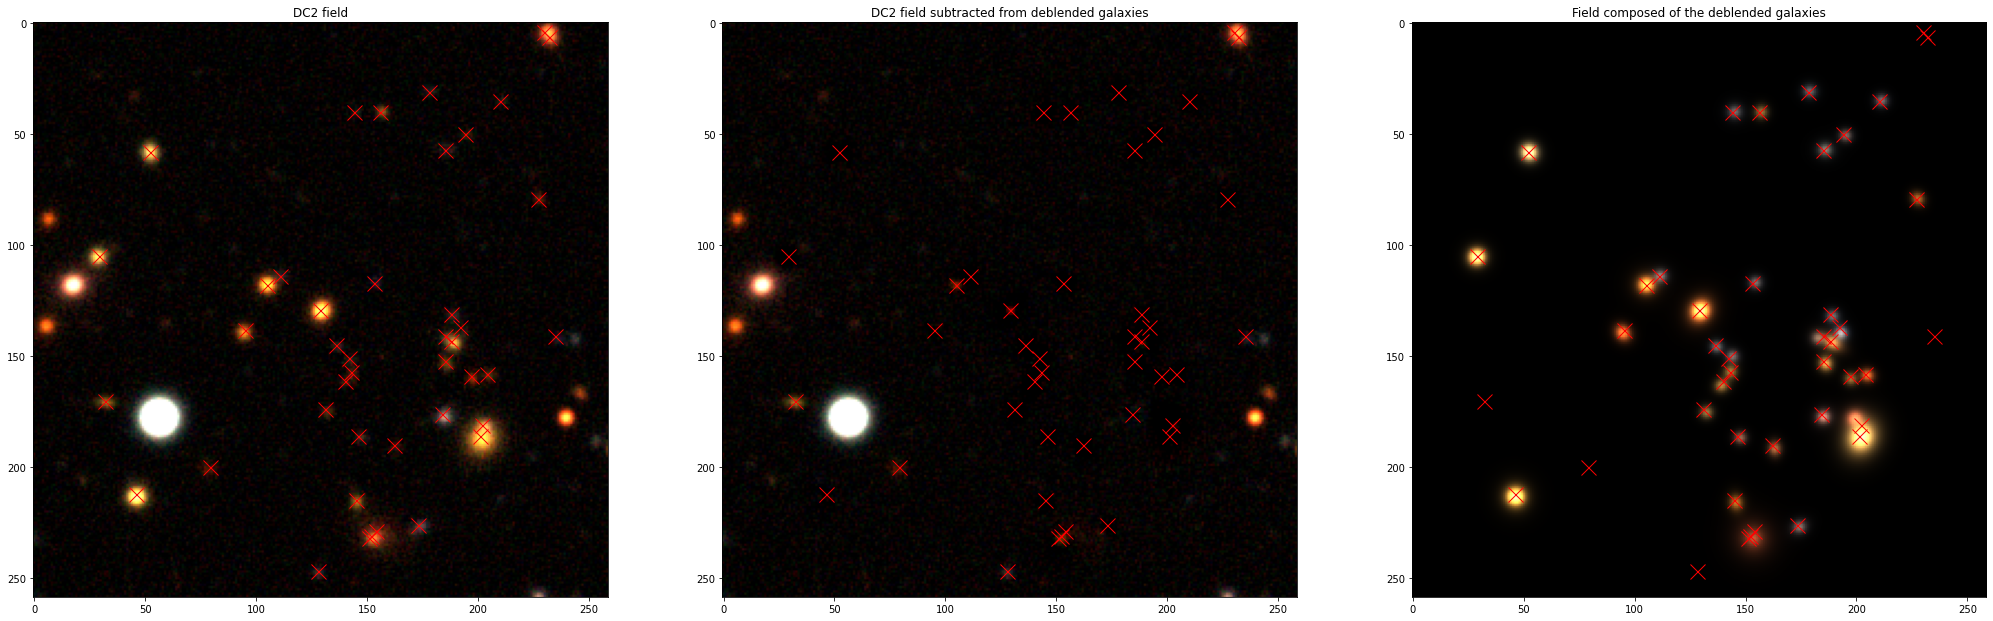

In [26]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center)):
    axes[0].plot((129+np.round(galaxy_distances_to_center[i][1])),(129+np.round(galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)
    axes[1].plot((129+np.round(galaxy_distances_to_center[i][1])),(129+np.round(galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)
    axes[2].plot((129+np.round(galaxy_distances_to_center[i][1])),(129+np.round(galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')


### Detection with SExtractor 

In [19]:
from debvader import detect_objects
galaxy_distances_to_center_sep = detect_objects(field_img, npeaks_per_iteration = 100, use_sep=True, factor=1.5)

using SExtractor for detection.


In [20]:
print("Number of galaxies detected by SExtractor : "+ str(len(galaxy_distances_to_center_sep)))

Number of galaxies detected by SExtractor : 53


In [21]:
import time
t0 = time.time()
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean, output_images_distribution, shifts, list_idx = deblend_field(net, 
                                                                                                                                                                                            field_img, 
                                                                                                                                                                                            galaxy_distances_to_center_sep,
                                                                                                                                                                                            optimise_positions=True)
print('The deblending of the field took '+str(time.time()-t0)+' seconds.')

Some galaxies are too close from the border of the field to be considered here.
The deblending of the field took 9.236950874328613 seconds.


In [22]:
output_images_mean.shape

(37, 59, 59, 6)

Text(0.5, 1.0, 'Field composed of the deblended galaxies')

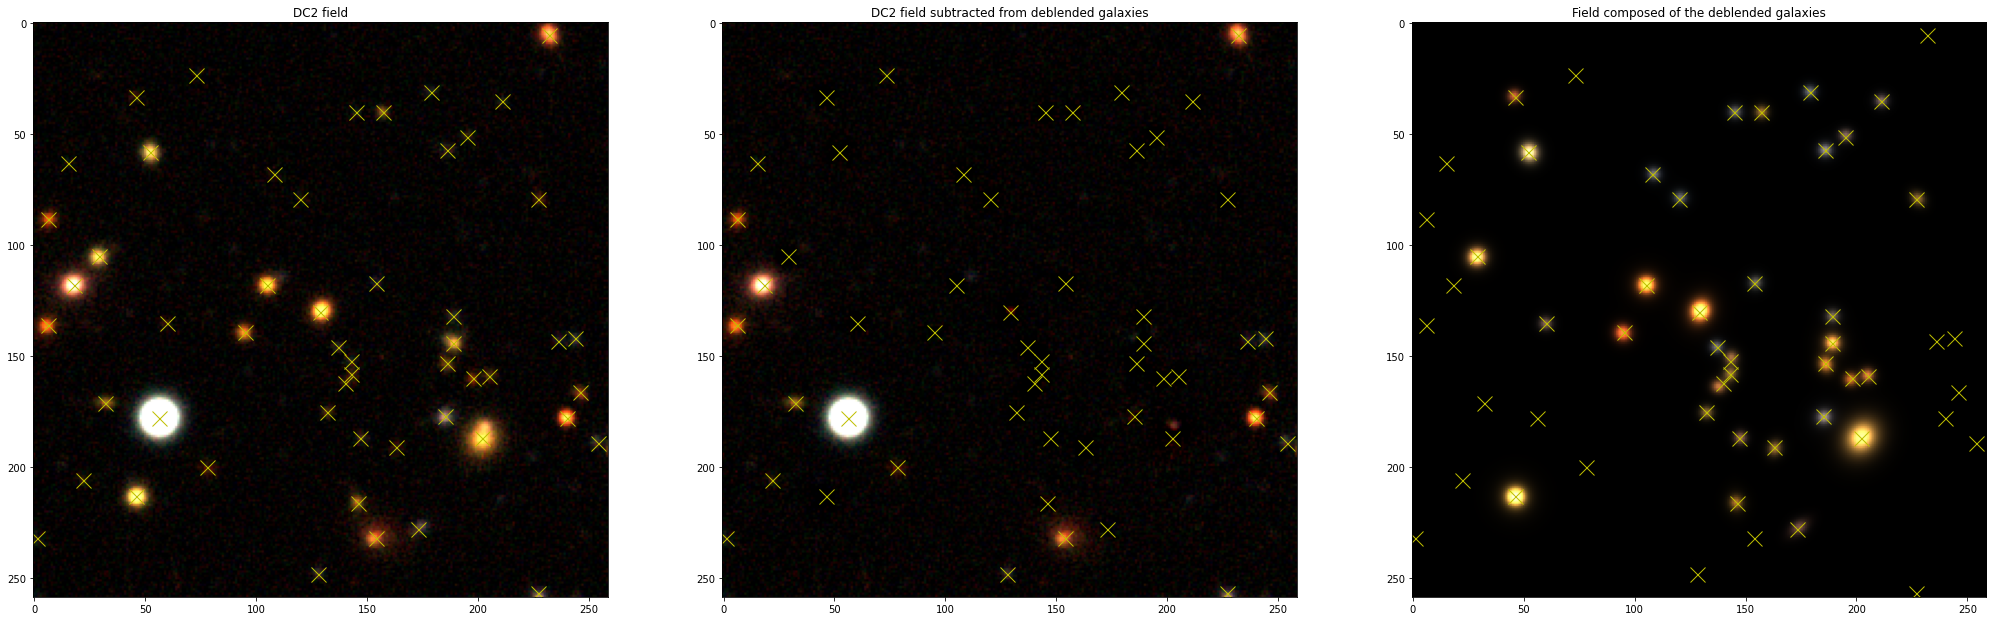

In [23]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center_sep)):
    axes[0].plot((129+np.round(galaxy_distances_to_center_sep[i][1])),(129+np.round(galaxy_distances_to_center_sep[i][0])), 'x', color = 'y', markersize = 15)
    axes[1].plot((129+np.round(galaxy_distances_to_center_sep[i][1])),(129+np.round(galaxy_distances_to_center_sep[i][0])), 'x', color = 'y', markersize = 15)
    axes[2].plot((129+np.round(galaxy_distances_to_center_sep[i][1])),(129+np.round(galaxy_distances_to_center_sep[i][0])), 'x', color = 'y', markersize = 15)

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')

In [18]:
print(type(galaxy_distances_to_center_sep[0][0].astype('float64')))

<class 'numpy.float64'>


In [19]:
import time
t0 = time.time()
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean, output_images_distribution, shifts, list_idx = deblend_field(net, 
                                                                                                                                                                                            field_img, 
                                                                                                                                                                                            galaxy_distances_to_center_sep,
                                                                                                                                                                                            optimise_positions=False)
print('The deblending of the field took '+str(time.time()-t0)+' seconds.')

Some galaxies are too close from the border of the field to be considered here.
The deblending of the field took 4.686343669891357 seconds.


Text(0.5, 1.0, 'Field composed of the deblended galaxies')

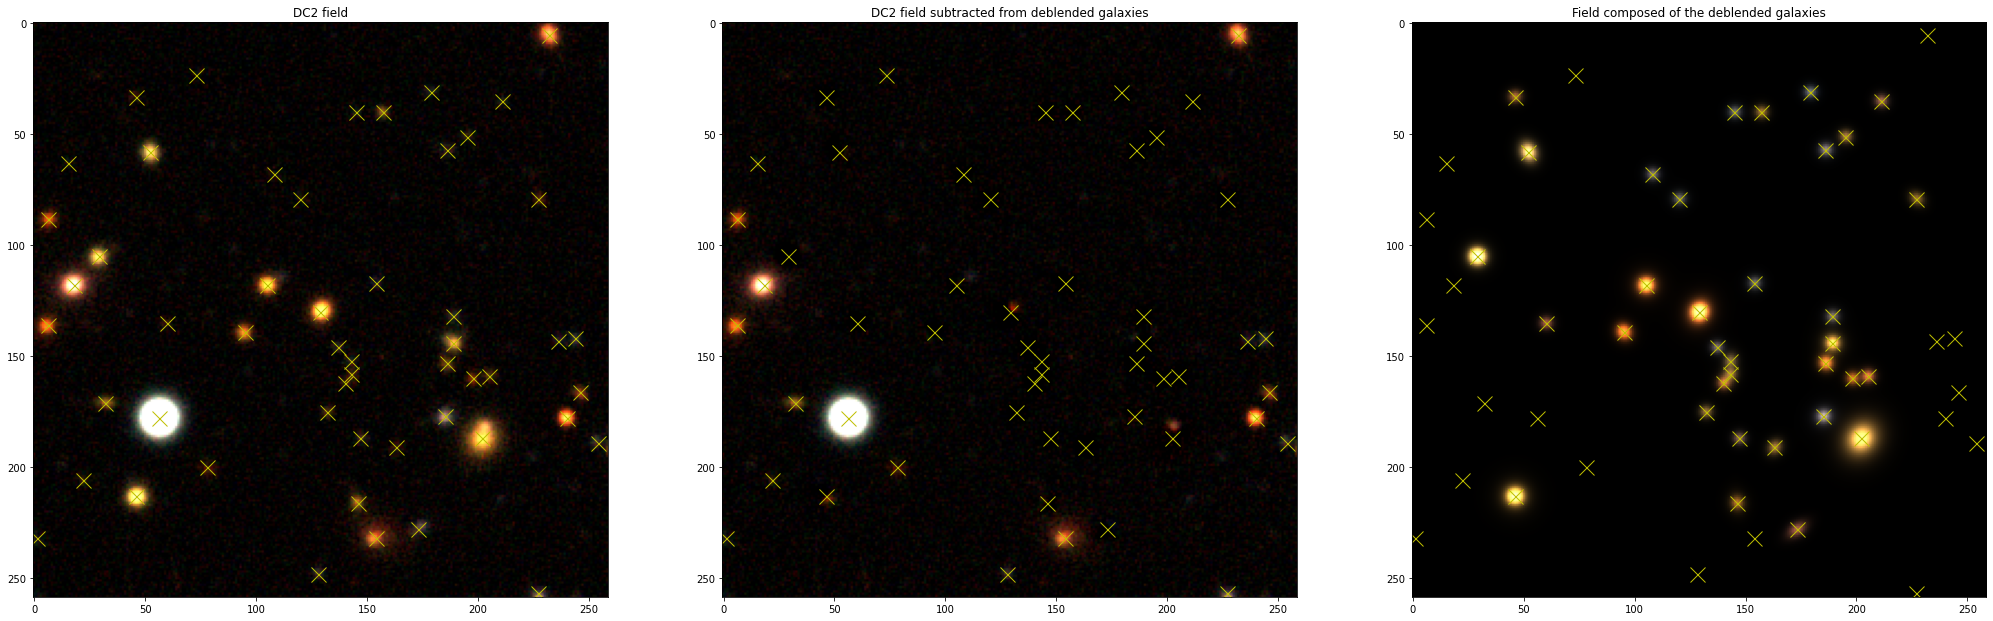

In [20]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center_sep)):
    axes[0].plot((129+np.round(galaxy_distances_to_center_sep[i][1])),(129+np.round(galaxy_distances_to_center_sep[i][0])), 'x', color = 'y', markersize = 15)
    axes[1].plot((129+np.round(galaxy_distances_to_center_sep[i][1])),(129+np.round(galaxy_distances_to_center_sep[i][0])), 'x', color = 'y', markersize = 15)
    axes[2].plot((129+np.round(galaxy_distances_to_center_sep[i][1])),(129+np.round(galaxy_distances_to_center_sep[i][0])), 'x', color = 'y', markersize = 15)

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')

### Detection with photutils

In [21]:
galaxy_distances_to_center_photutils = detect_objects(field_img, npeaks_per_iteration=100)

using photutils for detection.


In [22]:
print("Number of galaxies detected by photoutils : " + str(len(galaxy_distances_to_center_photutils)))

Number of galaxies detected by photoutils : 100


In [23]:
import time
t0 = time.time()
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean, output_images_distribution, shifts, list_idx = deblend_field(net, 
                                                                                                                                                                                            field_img, 
                                                                                                                                                                                            galaxy_distances_to_center_photutils,
                                                                                                                                                                                            optimise_positions=False)
print('The deblending of the field took '+str(time.time()-t0)+' seconds.')

Some galaxies are too close from the border of the field to be considered here.
The deblending of the field took 7.301235675811768 seconds.


Text(0.5, 1.0, 'Field composed of the deblended galaxies')

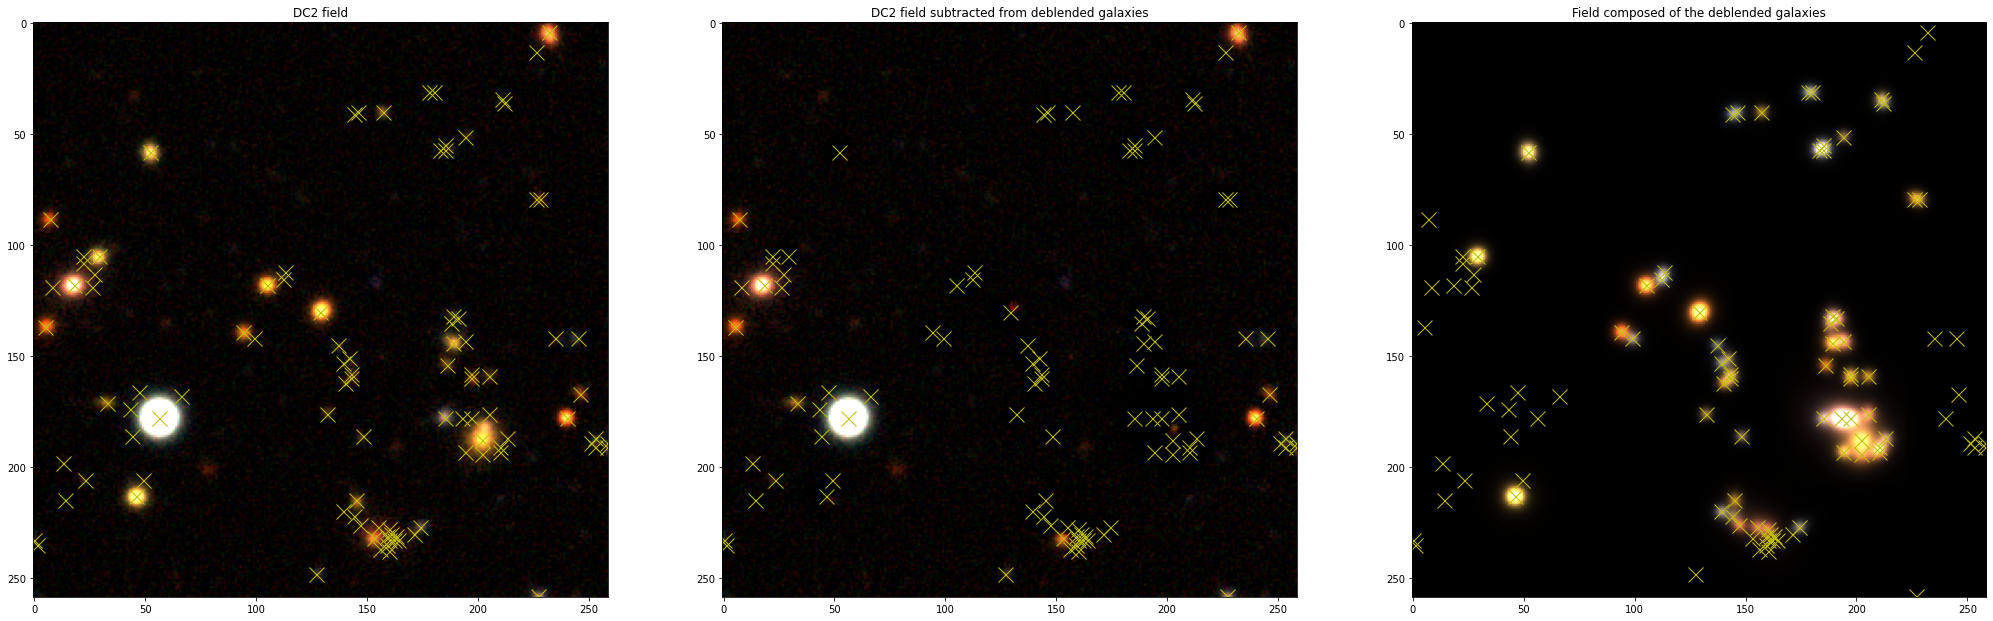

In [24]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center_photutils)):
    axes[0].plot((129+np.round(galaxy_distances_to_center_photutils[i][1])),(129+np.round(galaxy_distances_to_center_photutils[i][0])), 'x', color = 'y', markersize = 15)
    axes[1].plot((129+np.round(galaxy_distances_to_center_photutils[i][1])),(129+np.round(galaxy_distances_to_center_photutils[i][0])), 'x', color = 'y', markersize = 15)
    axes[2].plot((129+np.round(galaxy_distances_to_center_photutils[i][1])),(129+np.round(galaxy_distances_to_center_photutils[i][0])), 'x', color = 'y', markersize = 15)

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')

### Iterative deblending

Now, let's imagine that we want to iterate and to see if we can find galaxies that were not found at the first detection round. With `debvader` it is possible to use the `iterative_deblending` function.

First, let's load our field images and corresponding data again:

In [7]:
path_folder = os.path.dirname(os.path.abspath("__file__"))
field_img = np.load(path_folder+'/../data/dc2_imgs/field/field_img.npy', mmap_mode = 'c') # DC2 field image
cutout_galaxy_img = np.load(path_folder+'/../data/dc2_imgs/field/galaxies_from_field.npy', mmap_mode = 'c') # stamps from galaxies below a magnitude of 24.5 in the r-band
field_galaxies_distances_from_center = np.load(path_folder+'/../data/dc2_imgs/field/ra_dec_coord.npy', allow_pickle=True) # Distances from center of the different galaxies from object catalog (in pixels). Mag cut at 24.5
all_field_galaxies_distances_from_center_truth = np.load(path_folder+'/../data/dc2_imgs/field/gal_coordinates_complete_truth_catalog.npy', allow_pickle=True) # Distances from center of the field for the galaxies from the DC2 truth catalog (in pixels). Mag cut at 26

field_img_saving_iter = field_img.copy()

In [8]:
cutout_size = 59 # pixels
field_size = 259 # pixels
nb_of_bands = 6 # six LSST filters
use_sep = True

In [9]:
field_center = field_galaxies_distances_from_center[0]
galaxies_coord = field_galaxies_distances_from_center[1]

In [10]:
galaxies_coordinates = np.array(all_field_galaxies_distances_from_center_truth)

galaxy_distances_to_center = []
for i in range(all_field_galaxies_distances_from_center_truth.shape[0]):
    galaxy_distances_to_center.append((int(-field_center[1]+all_field_galaxies_distances_from_center_truth[i][1]), int(-field_center[0]+all_field_galaxies_distances_from_center_truth[i][0])))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

Now, use the `iterative_deblending` method to extract the galaxies iteratively. In the example below, no coordinates are provided as first step, but it can be done by feeding them to the `galaxy_distances_to_center` argument.

### Iterative deblending with SExtractor 

In [16]:
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean = iterative_deblending(net, 
                                                                                                                                                      field_img_saving_iter, 
                                                                                                                                                      galaxy_distances_to_center_in=None,
                                                                                                                                                      npeaks_per_iteration= 100, # important must be large enough to cover complete field...
                                                                                                                                                      optimise_positions=True,
                                                                                                                                                      epistemic_uncertainty_estimation=False,
                                                                                                                                                      epistemic_criterion= 20,
                                                                                                                                                      mse_criterion=20,
                                                                                                                                                      use_sep=True,
                                                                                                                                                      factor = 1.5)

using SExtractor for detection.
Some galaxies are too close from the border of the field to be considered here.
Deblend 37 more galaxy(ies)
iteration 1
using SExtractor for detection.
Deblend 6 more galaxy(ies)
43 galaxies found up to this step.
deta_mse = 0.00041091518294589235, mse_iteration = 7.652854391320802 and mse_previous_step = 7.652443476137856
iteration 2
using SExtractor for detection.
No galaxy deblended. End of the iterative procedure.
Deblend 0 more galaxy(ies)
using SExtractor for detection.
43 galaxies found up to this step.
deta_mse = 0.0, mse_iteration = 7.652854391320802 and mse_previous_step = 7.652854391320802
converged !


Text(0.5, 1.0, 'Epistemic uncertainty of field composed of the deblended galaxies')

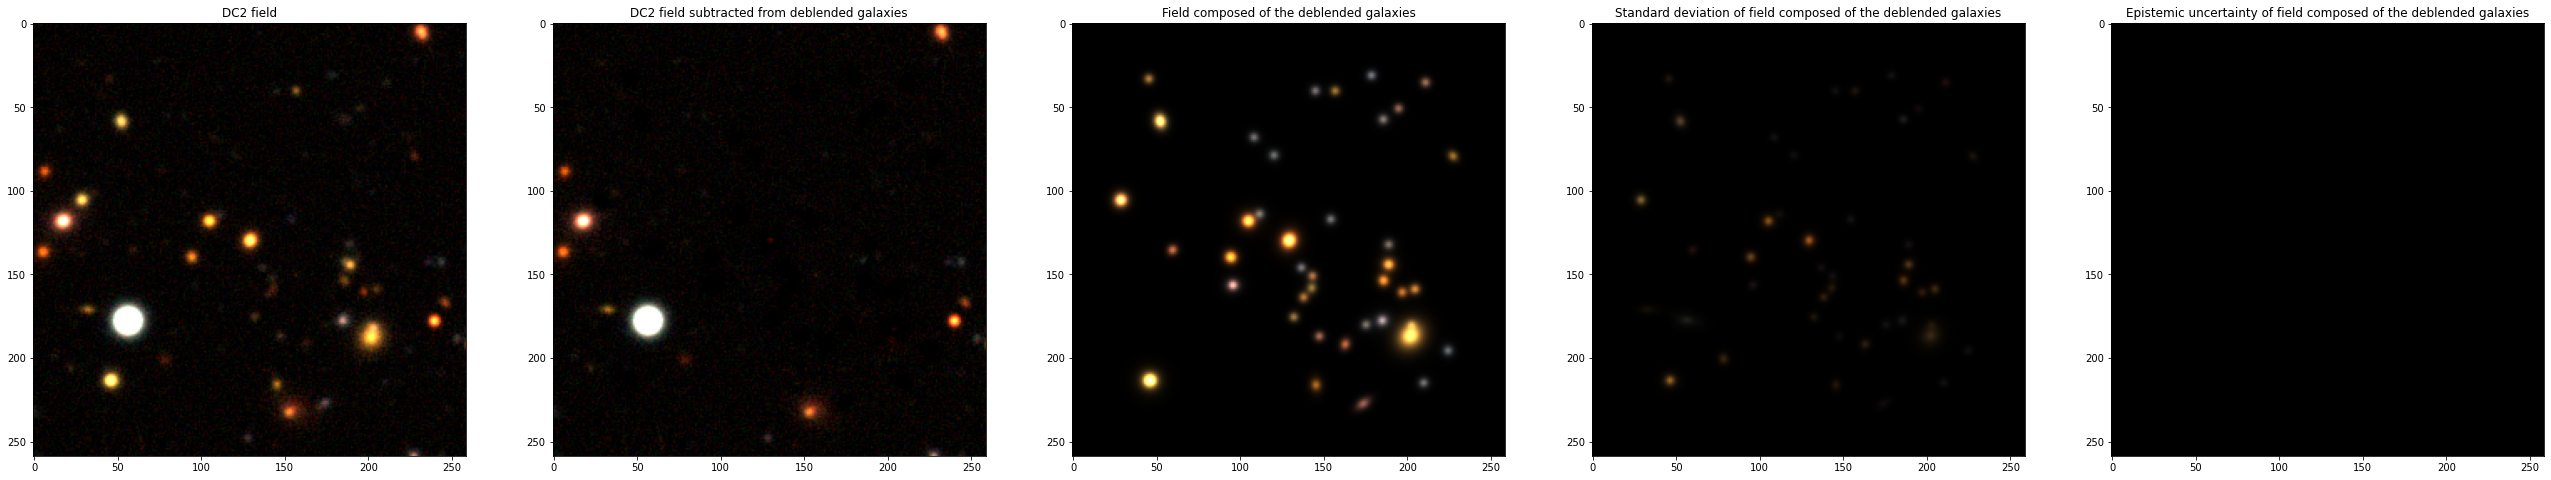

In [17]:
bands = [3,2,1]

fig, axes = plt.subplots(1,5, figsize = (45,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))
axes[4].imshow(np.clip(denoised_field_epistemic[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')
axes[4].set_title('Epistemic uncertainty of field composed of the deblended galaxies')

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

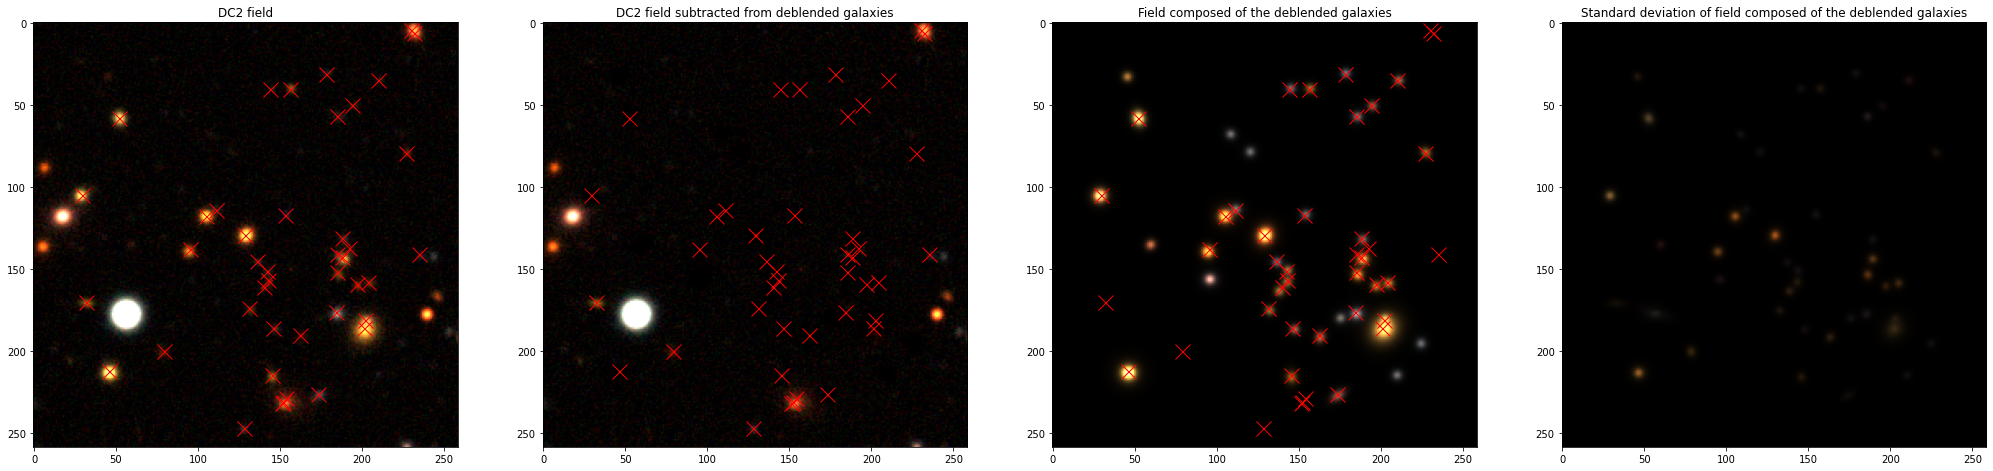

In [18]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center)):
    axes[0].plot((129+np.round(galaxy_distances_to_center[i][1])),(129+np.round(galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)
    axes[1].plot((129+np.round(galaxy_distances_to_center[i][1])),(129+np.round(galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)
    axes[2].plot((129+np.round(galaxy_distances_to_center[i][1])),(129+np.round(galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)


axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

In [24]:
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean = iterative_deblending(net, 
                                                                                                                                                      field_img_saving_iter, 
                                                                                                                                                      galaxy_distances_to_center_in=None,
                                                                                                                                                      npeaks_per_iteration= 10,
                                                                                                                                                      optimise_positions=True,
                                                                                                                                                      epistemic_uncertainty_estimation=False,
                                                                                                                                                      epistemic_criterion= 20,
                                                                                                                                                      mse_criterion=20,
                                                                                                                                                      use_sep=True,
                                                                                                                                                      factor = 1.5)

using SExtractor for detection.
Some galaxies are too close from the border of the field to be considered here.
Deblend 7 more galaxy(ies)
iteration 1
using SExtractor for detection.
Some galaxies are too close from the border of the field to be considered here.
Deblend 5 more galaxy(ies)
12 galaxies found up to this step.
deta_mse = -7.105213302605051e-05, mse_iteration = 7.662191573140641 and mse_previous_step = 7.662262625273667
iteration 2
using SExtractor for detection.
Deblend 5 more galaxy(ies)
17 galaxies found up to this step.
deta_mse = -0.004732808504098962, mse_iteration = 7.657458764636542 and mse_previous_step = 7.662191573140641
iteration 3
using SExtractor for detection.
Deblend 2 more galaxy(ies)
19 galaxies found up to this step.
deta_mse = -0.00015565696192521017, mse_iteration = 7.6573031076746165 and mse_previous_step = 7.657458764636542
iteration 4
using SExtractor for detection.
Some galaxies are too close from the border of the field to be considered here.
No ga

Text(0.5, 1.0, 'Epistemic uncertainty of field composed of the deblended galaxies')

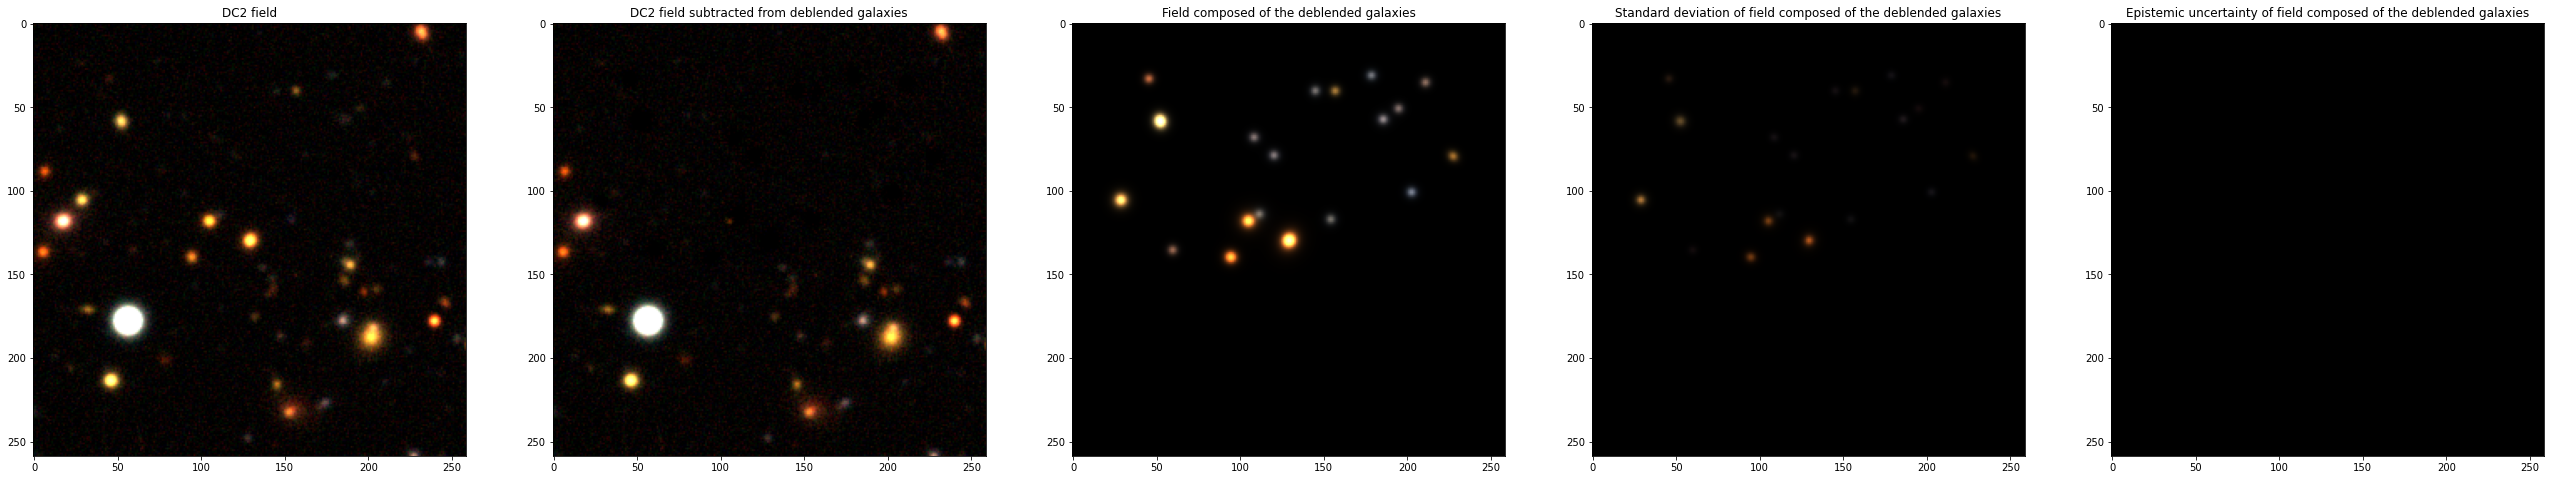

In [26]:
bands = [3,2,1]

fig, axes = plt.subplots(1,5, figsize = (45,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))
axes[4].imshow(np.clip(denoised_field_epistemic[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')
axes[4].set_title('Epistemic uncertainty of field composed of the deblended galaxies')

In [ ]:
field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean = iterative_deblending(net, 
                                                                                                                                                      field_img_saving_iter, 
                                                                                                                                                      galaxy_distances_to_center_in=None,
                                                                                                                                                      npeaks_per_iteration= 30,
                                                                                                                                                      optimise_positions=True,
                                                                                                                                                      epistemic_uncertainty_estimation=True,
                                                                                                                                                      epistemic_criterion= 0.2,
                                                                                                                                                      mse_criterion=0.1,
                                                                                                                                                      use_sep=False)

Some galaxies are too close from the border of the field to be considered here.


In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,5, figsize = (45,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))
axes[4].imshow(np.clip(denoised_field_epistemic[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')
axes[4].set_title('Epistemic uncertainty of field composed of the deblended galaxies')

In [ ]:
object_catalog_detection = np.load(path_folder+'/../data/dc2_imgs/field/gal_coordinates_complete_match.npy', allow_pickle=True) # detected by LSST pipeline below mag 26.

In [ ]:
len(object_catalog_detection)

In [43]:
galaxy_distances_to_center_obj = []
for i in range(object_catalog_detection.shape[0]):
    galaxy_distances_to_center_obj.append((int(-field_center[1]+object_catalog_detection[i][1]), int(-field_center[0]+object_catalog_detection[i][0])))

galaxy_distances_to_center_obj=np.array(galaxy_distances_to_center_obj)

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

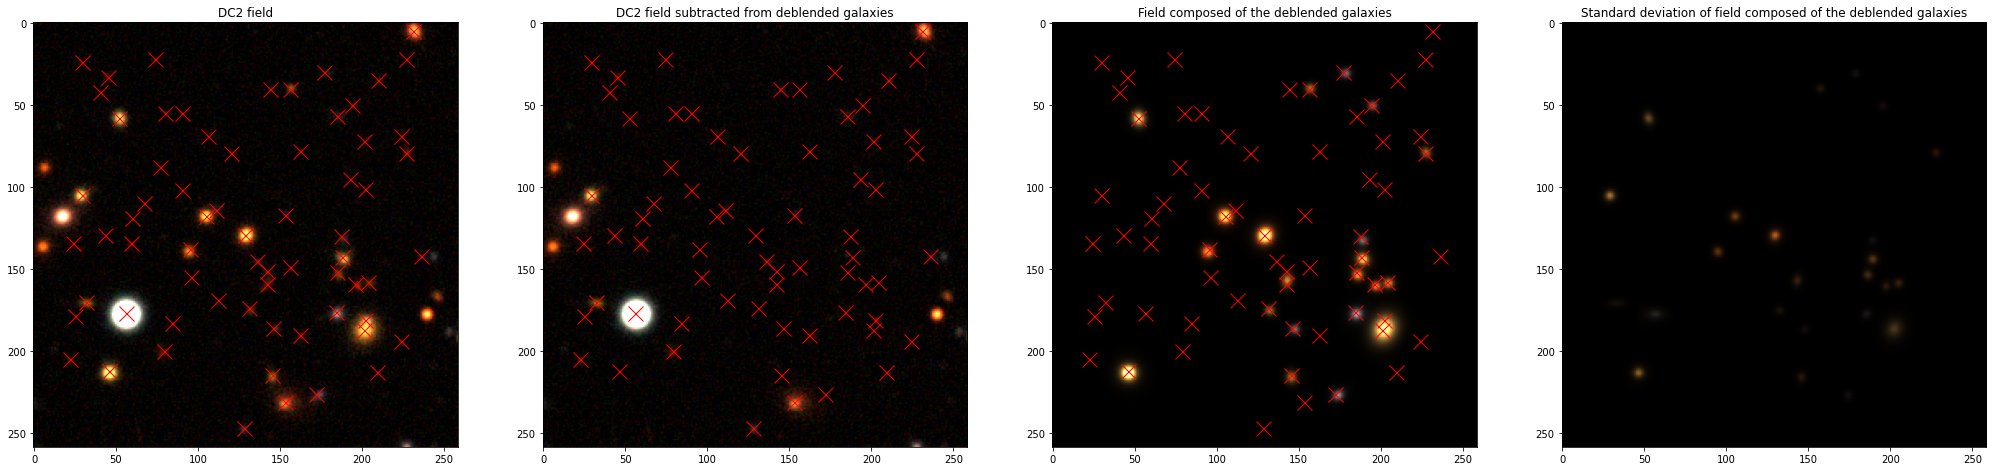

In [44]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center_obj)):
    axes[0].plot((129+np.round(galaxy_distances_to_center_obj[i][1])),(129+np.round(galaxy_distances_to_center_obj[i][0])), 'x', color = 'red', markersize = 15)
    axes[1].plot((129+np.round(galaxy_distances_to_center_obj[i][1])),(129+np.round(galaxy_distances_to_center_obj[i][0])), 'x', color = 'red', markersize = 15)
    axes[2].plot((129+np.round(galaxy_distances_to_center_obj[i][1])),(129+np.round(galaxy_distances_to_center_obj[i][0])), 'x', color = 'red', markersize = 15)


axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

In [45]:
path_folder = os.path.dirname(os.path.abspath("__file__"))
field_img = np.load(path_folder+'/../data/dc2_imgs/field/field_img.npy', mmap_mode = 'c') # DC2 field image
cutout_galaxy_img = np.load(path_folder+'/../data/dc2_imgs/field/galaxies_from_field.npy', mmap_mode = 'c') # stamps from galaxies below a magnitude of 24.5 in the r-band
field_galaxies_coordinates = np.load(path_folder+'/../data/dc2_imgs/field/ra_dec_coord.npy', allow_pickle=True) # Coordinates of the field and the different stamps (in pixels)

field_img_saving_iter = field_img.copy()

In [48]:
import scipy
from scipy import optimize
import skimage   
from skimage import metrics 

def fun (x, img, net_output): 
    return metrics.mean_squared_error(img,iterative_deblending(net, 
                                                                  field_img_saving_iter, 
                                                                  galaxy_distances_to_center_in=None,
                                                                  npeaks_per_iteration= int(x),
                                                                  cutout_images = None, 
                                                                  cutout_size = 59, 
                                                                  nb_of_bands = 6, 
                                                                  optimise_positions=True,
                                                                  epistemic_criterion= 0.25,
                                                                  mse_criterion=0.2)[2])

opt = optimize.least_squares(fun,(2.), args=(field_img_saving_iter[0],iterative_deblending(net, 
                                                                  field_img_saving_iter, 
                                                                  galaxy_distances_to_center_in=None,
                                                                  npeaks_per_iteration= 20,
                                                                  cutout_images = None, 
                                                                  cutout_size = 59, 
                                                                  nb_of_bands = 6, 
                                                                  optimise_positions=True,
                                                                  epistemic_criterion= 0.1,
                                                                  mse_criterion=0.)[2]), bounds=(0.,100))

Some galaxies are too close from the border of the field to be considered here.
Deblend 13 more galaxy(ies)
iteration 1
Deblend 1 more galaxy(ies)
14 galaxies found up to this step.
deta_mse = 0.0, mse_iteration = 7.662159209246486 and mse_previous_step = 7.662159209246486
iteration 2
Some galaxies are too close from the border of the field to be considered here.
Deblend 4 more galaxy(ies)
18 galaxies found up to this step.
deta_mse = 0.0, mse_iteration = 7.662159209246486 and mse_previous_step = 7.662159209246486
iteration 3
Some galaxies are too close from the border of the field to be considered here.
Deblend 4 more galaxy(ies)
converged on maximum peak per iteration.
converged !
Deblend 2 more galaxy(ies)
iteration 1
Some galaxies are too close from the border of the field to be considered here.
Deblend 1 more galaxy(ies)
3 galaxies found up to this step.
deta_mse = 0.0, mse_iteration = 7.660432042815892 and mse_previous_step = 7.660432042815892
iteration 2
Some galaxies are too cl

KeyboardInterrupt: 

In [ ]:
opt

It is also possible to access simply the different cutouts and the deblended galaxies from the cutouts. We plot only r-band here, but the output images are multi-bands (ugrizy)::

In [ ]:
cutout_images.shape
output_images_mean.shape

In [ ]:
fig, axes = plt.subplots(3,3, figsize = (12, 10))
for i in range (3):
    f1 = axes[i,0].imshow(cutout_images[i,:,:,2])
    f2 = axes[i,1].imshow(output_images_mean[i,:,:,2])
    f3 = axes[i,2].imshow(cutout_images[i,:,:,2]-output_images_mean[i,:,:,2])
    
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    
    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean')
    axes[i,2].set_title('Input - output mean')

As a safety check it is possible to verify that the shifts used are correct and that we retrieve the target galaxies:

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (30,10))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
for i in range(len(galaxy_distances_to_center)):
    axes[0].plot((129+np.round(galaxy_distances_to_center[i][1])),(129+np.round(galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)
    axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
    axes[1].plot((129+np.round(galaxy_distances_to_center[i][1])),(129+np.round(galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)
    axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
    axes[2].plot((129+np.round(galaxy_distances_to_center[i][1])),(129+np.round(galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)


### Two other DC2 field examples

Here I show the example of two other fields taken randomly within the DC2 simulation.

In [ ]:
field_img = np.load(path_folder+'/../data/dc2_imgs/field/field_img_2.npy', mmap_mode = 'c') # DC2 field image


field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean = iterative_deblending(net, 
                                                                                                                                                      field_img, 
                                                                                                                                                      galaxy_distances_to_center_in=None,
                                                                                                                                                      npeaks_per_iteration=10,
                                                                                                                                                      optimise_positions=True,
                                                                                                                                                      epistemic_uncertainty_estimation=True,
                                                                                                                                                      epistemic_criterion= 0.1,
                                                                                                                                                      mse_criterion=0.5)

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,5, figsize = (45,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))
axes[4].imshow(np.clip(denoised_field_epistemic[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')
axes[4].set_title('Epistemic uncertainty of field composed of the deblended galaxies')

In [ ]:
field_img = np.load(path_folder+'/../data/dc2_imgs/field/field_img_3.npy', mmap_mode = 'c') # DC2 field image

field_img, deblended_field_img, denoised_field, denoised_field_std, denoised_field_epistemic, cutout_images, output_images_mean = iterative_deblending(net, 
                                                                                                                                                      field_img,
                                                                                                                                                      galaxy_distances_to_center_in=None,
                                                                                                                                                      npeaks_per_iteration=10,
                                                                                                                                                      optimise_positions=True,
                                                                                                                                                      epistemic_uncertainty_estimation=True,
                                                                                                                                                      epistemic_criterion= 0.2,
                                                                                                                                                      mse_criterion=0.1)

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,5, figsize = (45,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(denoised_field_std[:,:,bands], a_min=0.0, a_max=1.))
axes[4].imshow(np.clip(denoised_field_epistemic[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')
axes[4].set_title('Epistemic uncertainty of field composed of the deblended galaxies')